In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from IPython.display import display
import astropy.units as u
from astropy.coordinates import EarthLocation
from pathlib import Path
from gammapy.catalog import SourceCatalog1LHAASO, CATALOG_REGISTRY
import numpy as np
from astropy.coordinates import SkyCoord
from gammapy.irf import load_irf_dict_from_file
from gammapy.data import FixedPointingInfo, Observation
from gammapy.maps import MapAxis, WcsGeom
from gammapy.datasets import MapDataset
from gammapy.modeling.models import (
    FoVBackgroundModel,
#    GaussianSpatialModel,
    Models,
#    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
import numpy as np
from scipy.optimize import curve_fit
import pickle
import time

In [3]:
# loading location ondrojev file
p = Path('../')
loc_ondrejov = p / 'config/location_ondrejov.txt'

with open(loc_ondrejov) as f:
    lat,lon,height = f.readline().split()

location_ondrejov = EarthLocation(
    lat = float(lat) * u.deg,
    lon = float(lon) * u.deg,
    height = float(height) * u.m)

print(f'Ondrejov location: {location_ondrejov}')

# Loading IRFs
irfs_dict = {}
for z in ['20','30','40']:
    irfs_dict[z] = p / f"IRFs/data/sst1m_stereo/0_4/bcf/ze{z}_az180_nsb100_gc0.75/SST1M_stereo_Zen{z}deg_gcut0.75_irfs.fits"

Ondrejov location: (3979453.55748948, 1050094.12597485, 4856894.19463016) m


## Create a list of pre-selected source, potentially visible above 40 deg elevation, according to SST1M sensitivity
### This pre-selection can be done running another notebook "xxx.ipynb'

In [4]:
catalog = CATALOG_REGISTRY.get_cls("1LHAASO")()

In [4]:
class Create_dataset():
    """Simulate a list of events based on instrumental IRF and pointing and source information
    
    Parameters
    ----------
    pointing_position : SkyCoord
        Where the telescope is pointing
    En : array
        Binning in energy for the simulation
    En_true : array
        Binning in reconstructed energy for the simulation
    source : SourceCatalog Class
    source_w : SkyModel `gammapy.modeling.models.cube.SkyModel`
    irfs : dict
        a dictionary containng the list of IRFs
    hour : float
        exposure of the simulation
    force_gamma : None or float
        If force_gamma is a number it overwrites the photon index of the model
    force_norm : None or float [TeV-1 s-1 cm-2] @ 3TeV en ref for WCDA or 50TeV for KM2A
        If force_norm is a number it overwrites the normalisation of the model
    pointlike : bool
        True if the source in the model is pointlike
    mask_region : `gammapy.region`
        Example of spatial region from `CircleSkyRegion`
        crop = CircleSkyRegion(center=self.source_w.spatial_model.position.icrs, radius=0.2*u.deg)

    Returns
    -------
    dataset : `gammapy.datasets.map.MapDataset`
        Map of the predicted signal counts.
    """
    
    def __init__(self,pointing_position,En,En_true,source,source_w,irfs,hour=20.0,force_gamma=None,force_norm=None,pointlike=True,source_k=None,mask_reg=None,offset_max=4,seed=None):
        self.fov = (9.0, 9.0)
        self.pointing_position = pointing_position
        self.En = En
        self.En_true = En_true
        self.source = source
        self.source_w = source_w
        if source_k:
            self.source_k = source_k
            self.spatial_model_k  = self.source_k.spatial_model
            self.spectral_model_k = self.source_k.spectral_model
        self.irfs = irfs
        self.hour = hour
        self.pointlike = pointlike
        self.spatial_model  = self.source_w.spatial_model
        self.spectral_model = self.source_w.spectral_model
        self.mask_reg = mask_reg
        self.offset_max = offset_max
        self.seed = seed

        if self.pointlike:
            if force_gamma:
                self.source_w.spectral_model.index.value = force_gamma
            if force_norm:
                self.source_w.spectral_model.amplitude.value = force_norm                
            self.gamma = self.source_w.spectral_model.index.value
            self.norm = self.source_w.spectral_model.amplitude.value
        
        # Main
        self.prepare_models()
        self.prepare_makers()
        self.simulate()
        
    def prepare_models(self):
        # Define the observation parameters (typically the observation duration and the pointing position):
        self.livetime = self.hour * u.hr
        # We want to simulate an observation pointing at a fixed position in the sky: `FixedPointingInfo`
        self.pointing = FixedPointingInfo(fixed_icrs=self.pointing_position.icrs,)
    
        # Define map geometry for binned simulation
        self.energy_reco = MapAxis.from_edges(self.En, unit="TeV", name="energy", interp="log")
        geom = WcsGeom.create(
            skydir=(self.pointing_position.icrs),
            binsz=0.01,
            width=(9.0, 9.0),
            frame="icrs",
            axes=[self.energy_reco],
        )
        self.geom = geom
        # It is usually useful to have a separate binning for the true energy axis
        self.energy_true = MapAxis.from_edges(self.En_true, unit="TeV", name="energy_true", interp="log")
    
        self.empty = MapDataset.create(geom, name="dataset-simu", energy_axis_true=self.energy_true)
        
        model_simu = SkyModel(
            spatial_model=self.spatial_model,
            spectral_model=self.spectral_model,
            name="model-simu",
        )
    
        bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

        bkg_model.spectral_model.norm.value = 1
        
        self.models = Models([model_simu, bkg_model])
    
        # Create an in-memory observation
        location = location_ondrejov
        self.obs = Observation.create(
            pointing=self.pointing, livetime=self.livetime, irfs=self.irfs, location=location
        )

    def prepare_makers(self):
        # Make the MapDataset
        maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    
        maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=self.offset_max * u.deg)
    
        dataset = maker.run(self.empty, self.obs)
    
        self.dataset = maker_safe_mask.run(dataset, self.obs)

    def simulate(self):
        if self.mask_reg != None:
            reg_mask = self.dataset.counts.geom.region_mask(self.mask_reg)
            self.dataset.mask_fit = reg_mask
        # Add the model on the dataset and Poisson fluctuate
        self.dataset.models = self.models
        if self.seed is not None:
            self.dataset.fake(self.seed)
        else:
            self.dataset.fake()

## The current choice of energy start @ 2TeV for Effective Area reason, and cut @ 25 TeV just to reproduce "WCDA LHAASO" model
### Energy range can be changed

In [5]:
# Defining parameters: Energy and Energy_True
En = np.logspace(0.3, 1.4, 10) # 2 TeV - 25 TeV
En_true = np.logspace(0, 2, 20)

# Dragonfly
### Study TS vs. Time
#### Run simulation for various exposure and 20-30-40 zenith distance. For each run, perform 10 simulations to average a bit fluctuations in results.

In [7]:
plt.ioff()
tstart = time.time()
# Put the exact name on the LHAASO catalogue
source_name_catalogue = '1LHAASO J2018+3643u'
source_name_file = source_name_catalogue.replace(' ','_')
source_name_file = source_name_catalogue.replace('*','x')
# source Nickname
src = 'Dragonfly'

source = catalog[source_name_catalogue]
source_w = source.sky_model(which='WCDA')
source_k = source.sky_model(which='KM2A')
offset_deg = 1.4*u.deg
pointing_position = SkyCoord(source_w.spatial_model.position.icrs.directional_offset_by(0,offset_deg), unit="deg", frame="icrs")

# Just to keep track of the simulation seed in case of debugging. Running 10 simulation to average fluctuation
seed_max = 10
seeds = np.arange(0,seed_max,1)
# Radius over which to integrate TS
radius = np.arange(0.0,5.01,0.02)
# Customise exposure [hour]
exposure = np.array([1, 5, 10, 25, 50, 100, 200])

for z in ['20','30','40']:
    irfs = load_irf_dict_from_file(irfs_dict[z])
    for seed in seeds:
        print(f'Seed = {seed:03d}')
        src_t = {}
        src_t['radius'] = radius
        for t in exposure:
            print(f'Time = {t} hours')
            src_t[t] = {}
            # Simulate source
            d = Create_dataset(pointing_position,En,En_true,source,source_w,irfs,hour=t,offset_max=4,seed=seed)
            n_sig = []
            sqrt_ts = []
            
            for r in src_t['radius']:
                if r < 0.01:
                    n_sig.append(0)
                    sqrt_ts.append(0)
                else:
                    regions = f"icrs;box({source_w.spatial_model.position.icrs.ra.deg}, {source_w.spatial_model.position.icrs.dec.deg}, {r}, {r})"
                    mask = d.dataset.counts.geom.region_mask(regions)
                    summed_stat = d.dataset._counts_statistic[mask.data].sum()
                    n_sig.append(summed_stat.n_sig)
                    sqrt_ts.append(summed_stat.sqrt_ts)
            src_t[t]['n_sig'] = n_sig
            src_t[t]['sqrt_ts'] = sqrt_ts
    
        if (seed is not None):
            outname = f'../data/{src}/z{z}/{src}_z{z}_sed_{seed:03d}.pkl'
        else:
            outname = f'../data/{src}/z{z}/{src}_z{z}.pkl'
        
        path = ''
        for fold in ['../data',f'/{src}',f'/z{z}']:
            path += fold
            Path(path).mkdir(exist_ok=True)
        
        with open(outname, 'wb') as f:
            pickle.dump(src_t, f)
        tstop = time.time()
        dt = tstop - tstart
        print(f"Elapsed time: {dt:.1f} sec = {dt/60:.2f} min = {dt/3600:.4f} hour")

Seed = 000
Time = 1 hours
Time = 5 hours
Time = 10 hours
Time = 25 hours
Time = 50 hours
Time = 100 hours
Time = 200 hours
Elapsed time: 379.2 sec = 6.32 min = 0.1053 hour
Seed = 001
Time = 1 hours
Time = 5 hours
Time = 10 hours
Time = 25 hours
Time = 50 hours
Time = 100 hours
Time = 200 hours
Elapsed time: 770.6 sec = 12.84 min = 0.2141 hour
Seed = 002
Time = 1 hours
Time = 5 hours
Time = 10 hours
Time = 25 hours
Time = 50 hours
Time = 100 hours
Time = 200 hours
Elapsed time: 1163.8 sec = 19.40 min = 0.3233 hour
Seed = 003
Time = 1 hours
Time = 5 hours
Time = 10 hours
Time = 25 hours
Time = 50 hours
Time = 100 hours
Time = 200 hours
Elapsed time: 1558.5 sec = 25.98 min = 0.4329 hour
Seed = 004
Time = 1 hours
Time = 5 hours
Time = 10 hours
Time = 25 hours
Time = 50 hours
Time = 100 hours
Time = 200 hours
Elapsed time: 1955.0 sec = 32.58 min = 0.5430 hour
Seed = 005
Time = 1 hours
Time = 5 hours
Time = 10 hours
Time = 25 hours
Time = 50 hours
Time = 100 hours
Time = 200 hours
Elapsed ti

KeyboardInterrupt: 

# After you run the simulations and stored the data you can create the plots:

In [6]:
plt.ioff()
# Put the exact name on the LHAASO catalogue
source_name_catalogue = '1LHAASO J2018+3643u'
source_name_file = source_name_catalogue.replace(' ','_')
source_name_file = source_name_catalogue.replace('*','x')
# source Nickname
src = 'Dragonfly'

source = catalog[source_name_catalogue]
source_w = source.sky_model(which='WCDA')
source_k = source.sky_model(which='KM2A')
offset_deg = 1.4*u.deg

seed_max = 10
seeds = np.arange(0,seed_max,1)
# Radius over which to integrate TS
radius = np.arange(0.0,5.01,0.02)
# Customise exposure [hour]
exposure = np.array([1, 5, 10, 25, 50, 100, 200])


In [20]:
plt.ioff()
save_plot = True

def model_func(x, a, b):
    return a * np.sqrt(x) + b

ext = (
        0
        if source_w.to_dict()["spatial"]["type"] == "PointSpatialModel"
        else source_w.spatial_model.sigma.value
    )

pkl = {}
len_seeds = len(seeds)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(30, 15))
fig.suptitle(f"{len_seeds}-AVG TS simulation ext: {ext:.2f} deg, norm={source_w.spectral_model.amplitude.value:.2e}, gamma={source_w.spectral_model.index.value:.2e}, src={src}")
for z, a, b, c in zip(["20", "30", "40"], [ax1, ax4, ax7], [ax2, ax5, ax8], [ax3, ax6, ax9]):
    for seed in seeds:
        outname = f"../data/{src}/z{z}/{src}_z{z}_sed_{seed:03d}.pkl"
        file = open(outname, "rb")
        data = pickle.load(file)
        pkl[f"{seed:03d}"] = data
        std_deviation_per_line = {}
        a.set_title(f"Z{z}: TS (cash) statistic vs. Rad dist (for different Exposure")
        b.set_title(f"Z{z}: {len_seeds}-AVG TS (cash) statistic vs. Integration region (vs. Time)")
        c.set_title(f"Z{z}: {len_seeds}-AVG TS max (cash) statistic vs. Exposure Time")
        a.set_xlabel("Radial distance [deg]")
        a.set_ylabel("sqrt(TS) Cash statistic [sigma]")
        b.set_xlabel("Radial distance [deg]")
        b.set_ylabel("AVG sqrt(TS) Cash statistic [sigma]")
        c.set_xlabel("Exposure Time [hours]")
        c.set_ylabel("sqrt(TS) Cash statistic [sigma]")
        color = iter(cm.rainbow(np.linspace(0, 1, num=len(exposure))))
    sigma_max, ts_within_02_deg, sigma_max_err = [], [], []
    for t in exposure:
        col = next(color)
        first = True
        ts_arr = np.zeros_like(radius)
        test = []
        for seed in seeds:
            prefix = "" if first else "_"
            src_t = pkl[f"{seed:03d}"]
            pl = a.plot(
                src_t["radius"],
                src_t[t]["sqrt_ts"],
                ".-",
                label=f"{prefix}{t} hours",
                c=col,
            )
            a.axvline(
                src_t["radius"][np.argmax(src_t[t]["sqrt_ts"])],
                c=pl[0].get_color(),
                ls="--",
            )
            ts_arr += src_t[t]["sqrt_ts"]
            first = False
            test.append(pkl[f"{seed:03d}"][t]["sqrt_ts"])
        ts_arr /= len_seeds
        ts_within_02_deg.append(ts_arr[10])
        stacked_array = np.stack(test)
        std_deviation_per_line[t] = np.std(stacked_array, axis=0)
        sigma_max.append(max(ts_arr))
        sigma_max_err.append(std_deviation_per_line[t][np.argmax(ts_arr)])
        pl = b.errorbar(
            src_t["radius"],
            ts_arr,
            yerr=std_deviation_per_line[t],
            marker="x",
            ls="-",
            label=f"AVG {t} hours",
            c=col,
        )
        b.axvline(
            src_t["radius"][np.argmax(ts_arr)], c=pl[0].get_color(), ls="--"
        )
    c.errorbar(
        exposure,
        sigma_max,
        yerr=sigma_max_err,
        marker="x",
        ls="-",
        label="max sqrt(TS)",
    )
    c.errorbar(
        exposure,
        ts_within_02_deg,
        yerr=std_deviation_per_line[t][10],
        marker="x",
        ls="-",
        label="sqrt(TS) within 0.2 deg",
    )
    params, params_covariance_matrix = curve_fit(
        model_func, exposure, sigma_max
    )
    x = np.arange(0, 200, 0.5)
    c.plot(x, model_func(x, *params), label=f"fit: {params[0]:.3f}*sqrt(t) {params[1]:+.3f}", ls="--", c="k")
    a.legend(loc=1)
    b.legend()
    c.legend()
    a.set_ylim(-3, 10.5)
    b.set_ylim(-3, 10.5)
    b.set_ylim(-2, 8.5)
    a.set_xlim(-0.1, 5.1)
    b.set_xlim(-0.1, 5.1)
fig.tight_layout()
if save_plot:
    path = ''
    for fold in ['../debug',f'/{src}']:
        path += fold
        Path(path).mkdir(exist_ok=True)
    figname = f"../debug/{src}/multi_{len_seeds:03d}-AVG_norm_{source_w.spectral_model.amplitude.value:.2e}_gamma_{source_w.spectral_model.index.value:.2e}_ext_{ext:.2f}deg.png"
fig.savefig(figname)

[ 0.50812939 -0.11563875]
[0.44923128 0.11423937]
[ 0.4528949  -0.15189121]


# The rest is just debugging plot

In [86]:
plt.ioff()
# Put the exact name on the LHAASO catalogue
source_name_catalogue = '1LHAASO J2018+3643u'
source_name_file = source_name_catalogue.replace(' ','_')
source_name_file = source_name_catalogue.replace('*','x')
# source Nickname
src = 'Dragonfly'

source = catalog[source_name_catalogue]
source_w = source.sky_model(which='WCDA')
source_k = source.sky_model(which='KM2A')
offset_deg = 1.4*u.deg

# Radius over which to integrate TS
radius = np.arange(0.0,5.01,0.02)
# Customise exposure [hour]
exposure = np.array([1, 5, 10, 25, 50, 100, 200])

def model_func(x, a, b):
    return a * np.sqrt(x) + b

A20,A30,A40 = [],[],[]
B20,B30,B40 = [],[],[]
A20_err,A30_err,A40_err = [],[],[]
B20_err,B30_err,B40_err = [],[],[]
resid20,resid30,resid40 = [],[],[]
save_plot = True
for seed_max in [5,10,20,40,80,120,143]:
    seeds = np.arange(0,seed_max,1)
    ext = (
            0
            if source_w.to_dict()["spatial"]["type"] == "PointSpatialModel"
            else source_w.spatial_model.sigma.value
        )
    
    pkl = {}
    len_seeds = len(seeds)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(30, 15))
    fig.suptitle(f"{len_seeds}-AVG TS simulation ext: {ext:.2f} deg, norm={source_w.spectral_model.amplitude.value:.2e}, gamma={source_w.spectral_model.index.value:.2e}, src={src}")
    for z, a, b, c, A, A_err, B, B_err, res in zip(["20", "30", "40"], [ax1, ax4, ax7], [ax2, ax5, ax8], [ax3, ax6, ax9], [A20,A30,A40], [A20_err,A30_err,A40_err], [B20,B30,B40], [B20_err,B30_err,B40_err], [resid20,resid30,resid40]):
        for seed in seeds:
            outname = f"../data/{src}/z{z}/{src}_z{z}_sed_{seed:03d}.pkl"
            file = open(outname, "rb")
            data = pickle.load(file)
            pkl[f"{seed:03d}"] = data
            std_deviation_per_line = {}
            a.set_title(f"Z{z}: TS (cash) statistic vs. Rad dist (for different Exposure")
            b.set_title(f"Z{z}: {len_seeds}-AVG TS (cash) statistic vs. Integration region (vs. Time)")
            c.set_title(f"Z{z}: {len_seeds}-AVG TS max (cash) statistic vs. Exposure Time")
            a.set_xlabel("Radial distance [deg]")
            a.set_ylabel("sqrt(TS) Cash statistic [sigma]")
            b.set_xlabel("Radial distance [deg]")
            b.set_ylabel("AVG sqrt(TS) Cash statistic [sigma]")
            c.set_xlabel("Exposure Time [hours]")
            c.set_ylabel("sqrt(TS) Cash statistic [sigma]")
            color = iter(cm.rainbow(np.linspace(0, 1, num=len(exposure))))
        sigma_max, ts_within_02_deg, sigma_max_err = [], [], []
        for t in exposure:
            col = next(color)
            first = True
            ts_arr = np.zeros_like(radius)
            test = []
            for seed in seeds:
                prefix = "" if first else "_"
                src_t = pkl[f"{seed:03d}"]
                pl = a.plot(
                    src_t["radius"],
                    src_t[t]["sqrt_ts"],
                    ".-",
                    label=f"{prefix}{t} hours",
                    c=col,
                )
                a.axvline(
                    src_t["radius"][np.argmax(src_t[t]["sqrt_ts"])],
                    c=pl[0].get_color(),
                    ls="--",
                )
                ts_arr += src_t[t]["sqrt_ts"]
                first = False
                test.append(pkl[f"{seed:03d}"][t]["sqrt_ts"])
            ts_arr /= len_seeds
            ts_within_02_deg.append(ts_arr[10])
            stacked_array = np.stack(test)
            std_deviation_per_line[t] = np.std(stacked_array, axis=0)
            sigma_max.append(max(ts_arr))
            sigma_max_err.append(std_deviation_per_line[t][np.argmax(ts_arr)])
            pl = b.errorbar(
                src_t["radius"],
                ts_arr,
                yerr=std_deviation_per_line[t],
                marker="x",
                ls="-",
                label=f"AVG {t} hours",
                c=col,
            )
            b.axvline(
                src_t["radius"][np.argmax(ts_arr)], c=pl[0].get_color(), ls="--"
            )
        c.errorbar(
            exposure,
            sigma_max,
            yerr=sigma_max_err,
            marker="x",
            ls="-",
            label="max sqrt(TS)",
        )
        c.errorbar(
            exposure,
            ts_within_02_deg,
            yerr=std_deviation_per_line[t][10],
            marker="x",
            ls="-",
            label="sqrt(TS) within 0.2 deg",
        )
        params, params_covariance_matrix = curve_fit(
            model_func, exposure, sigma_max
        )
        x = np.arange(0, 200, 0.5)
        c.plot(x, model_func(x, *params), label=f"fit: {params[0]:.3f}*sqrt(t) {params[1]:+.3f}", ls="--", c="k")
        res.append(np.asarray(model_func(exposure, *params)) - np.asarray(sigma_max))
        A.append(params[0])
        B.append(params[1])
        A_err.append(params_covariance_matrix[0][0])
        B_err.append(params_covariance_matrix[1][1])
        a.legend(loc=1)
        b.legend()
        c.legend()
        a.set_ylim(-3, 10.5)
        b.set_ylim(-3, 10.5)
        a.set_xlim(-0.1, 5.1)
        b.set_xlim(-0.1, 5.1)
    fig.tight_layout()
    if save_plot:
        path = ''
        for fold in ['../debug',f'/{src}']:
            path += fold
            Path(path).mkdir(exist_ok=True)
        figname = f"../debug/{src}/multi_{len_seeds:03d}-AVG_norm_{source_w.spectral_model.amplitude.value:.2e}_gamma_{source_w.spectral_model.index.value:.2e}_ext_{ext:.2f}deg.png"
    fig.savefig(figname)
    plt.close()

In [88]:
plt.ioff()
# Put the exact name on the LHAASO catalogue
source_name_catalogue = '1LHAASO J0007+7303u'
source_name_file = source_name_catalogue.replace(' ','_')
source_name_file = source_name_catalogue.replace('*','x')
# source Nickname
src = 'CTA1'

source = catalog[source_name_catalogue]
source_w = source.sky_model(which='WCDA')
source_k = source.sky_model(which='KM2A')
offset_deg = 1.4*u.deg

# Radius over which to integrate TS
radius = np.arange(0.0,5.01,0.02)
# Customise exposure [hour]
exposure = np.array([1, 5, 10, 25, 50, 100, 200])

def model_func(x, a, b):
    return a * np.sqrt(x) + b

A20,A30,A40 = [],[],[]
B20,B30,B40 = [],[],[]
A20_err,A30_err,A40_err = [],[],[]
B20_err,B30_err,B40_err = [],[],[]
resid20,resid30,resid40 = [],[],[]
save_plot = True
for seed_max in [5,10,25,50]:
    seeds = np.arange(0,seed_max,1)
    ext = (
            0
            if source_w.to_dict()["spatial"]["type"] == "PointSpatialModel"
            else source_w.spatial_model.sigma.value
        )
    
    pkl = {}
    len_seeds = len(seeds)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(30, 15))
    fig.suptitle(f"{len_seeds}-AVG TS simulation ext: {ext:.2f} deg, norm={source_w.spectral_model.amplitude.value:.2e}, gamma={source_w.spectral_model.index.value:.2e}, src={src}")
    for z, a, b, c, A, A_err, B, B_err, res in zip(["20", "30", "40"], [ax1, ax4, ax7], [ax2, ax5, ax8], [ax3, ax6, ax9], [A20,A30,A40], [A20_err,A30_err,A40_err], [B20,B30,B40], [B20_err,B30_err,B40_err], [resid20,resid30,resid40]):
        for seed in seeds:
            outname = f"../data/{src}/z{z}/{src}_z{z}_sed_{seed:03d}.pkl"
            file = open(outname, "rb")
            data = pickle.load(file)
            pkl[f"{seed:03d}"] = data
            std_deviation_per_line = {}
            a.set_title(f"Z{z}: TS (cash) statistic vs. Rad dist (for different Exposure")
            b.set_title(f"Z{z}: {len_seeds}-AVG TS (cash) statistic vs. Integration region (vs. Time)")
            c.set_title(f"Z{z}: {len_seeds}-AVG TS max (cash) statistic vs. Exposure Time")
            a.set_xlabel("Radial distance [deg]")
            a.set_ylabel("sqrt(TS) Cash statistic [sigma]")
            b.set_xlabel("Radial distance [deg]")
            b.set_ylabel("AVG sqrt(TS) Cash statistic [sigma]")
            c.set_xlabel("Exposure Time [hours]")
            c.set_ylabel("sqrt(TS) Cash statistic [sigma]")
            color = iter(cm.rainbow(np.linspace(0, 1, num=len(exposure))))
        sigma_max, ts_within_02_deg, sigma_max_err = [], [], []
        for t in exposure:
            col = next(color)
            first = True
            ts_arr = np.zeros_like(radius)
            test = []
            for seed in seeds:
                prefix = "" if first else "_"
                src_t = pkl[f"{seed:03d}"]
                pl = a.plot(
                    src_t["radius"],
                    src_t[t]["sqrt_ts"],
                    ".-",
                    label=f"{prefix}{t} hours",
                    c=col,
                )
                a.axvline(
                    src_t["radius"][np.argmax(src_t[t]["sqrt_ts"])],
                    c=pl[0].get_color(),
                    ls="--",
                )
                ts_arr += src_t[t]["sqrt_ts"]
                first = False
                test.append(pkl[f"{seed:03d}"][t]["sqrt_ts"])
            ts_arr /= len_seeds
            ts_within_02_deg.append(ts_arr[10])
            stacked_array = np.stack(test)
            std_deviation_per_line[t] = np.std(stacked_array, axis=0)
            sigma_max.append(max(ts_arr))
            sigma_max_err.append(std_deviation_per_line[t][np.argmax(ts_arr)])
            pl = b.errorbar(
                src_t["radius"],
                ts_arr,
                yerr=std_deviation_per_line[t],
                marker="x",
                ls="-",
                label=f"AVG {t} hours",
                c=col,
            )
            b.axvline(
                src_t["radius"][np.argmax(ts_arr)], c=pl[0].get_color(), ls="--"
            )
        c.errorbar(
            exposure,
            sigma_max,
            yerr=sigma_max_err,
            marker="x",
            ls="-",
            label="max sqrt(TS)",
        )
        c.errorbar(
            exposure,
            ts_within_02_deg,
            yerr=std_deviation_per_line[t][10],
            marker="x",
            ls="-",
            label="sqrt(TS) within 0.2 deg",
        )
        params, params_covariance_matrix = curve_fit(
            model_func, exposure, sigma_max
        )
        x = np.arange(0, 200, 0.5)
        c.plot(x, model_func(x, *params), label=f"fit: {params[0]:.3f}*sqrt(t) {params[1]:+.3f}", ls="--", c="k")
        res.append(np.asarray(model_func(exposure, *params)) - np.asarray(sigma_max))
        A.append(params[0])
        B.append(params[1])
        A_err.append(params_covariance_matrix[0][0])
        B_err.append(params_covariance_matrix[1][1])
        a.legend(loc=1)
        b.legend()
        c.legend()
        a.set_ylim(-3, 35.5)
        b.set_ylim(-3, 35.5)
        a.set_xlim(-0.1, 5.1)
        b.set_xlim(-0.1, 5.1)
    fig.tight_layout()
    if save_plot:
        path = ''
        for fold in ['../debug',f'/{src}']:
            path += fold
            Path(path).mkdir(exist_ok=True)
        figname = f"../debug/{src}/multi_{len_seeds:03d}-AVG_norm_{source_w.spectral_model.amplitude.value:.2e}_gamma_{source_w.spectral_model.index.value:.2e}_ext_{ext:.2f}deg.png"
    fig.savefig(figname)
    plt.close()

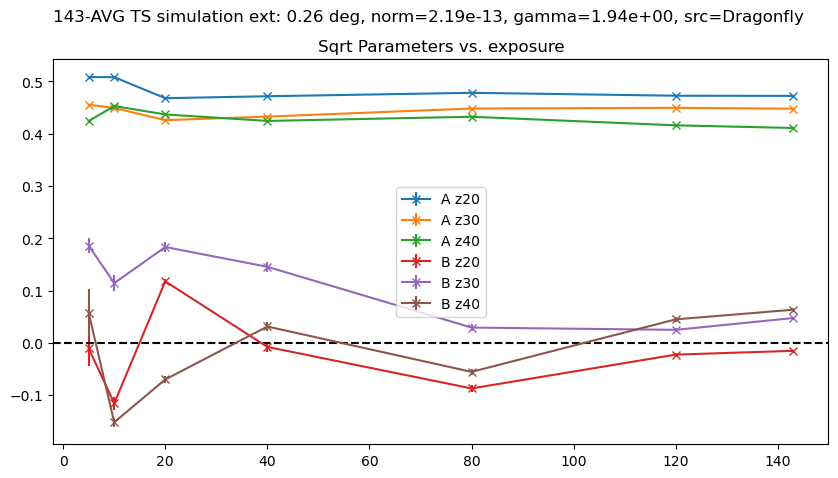

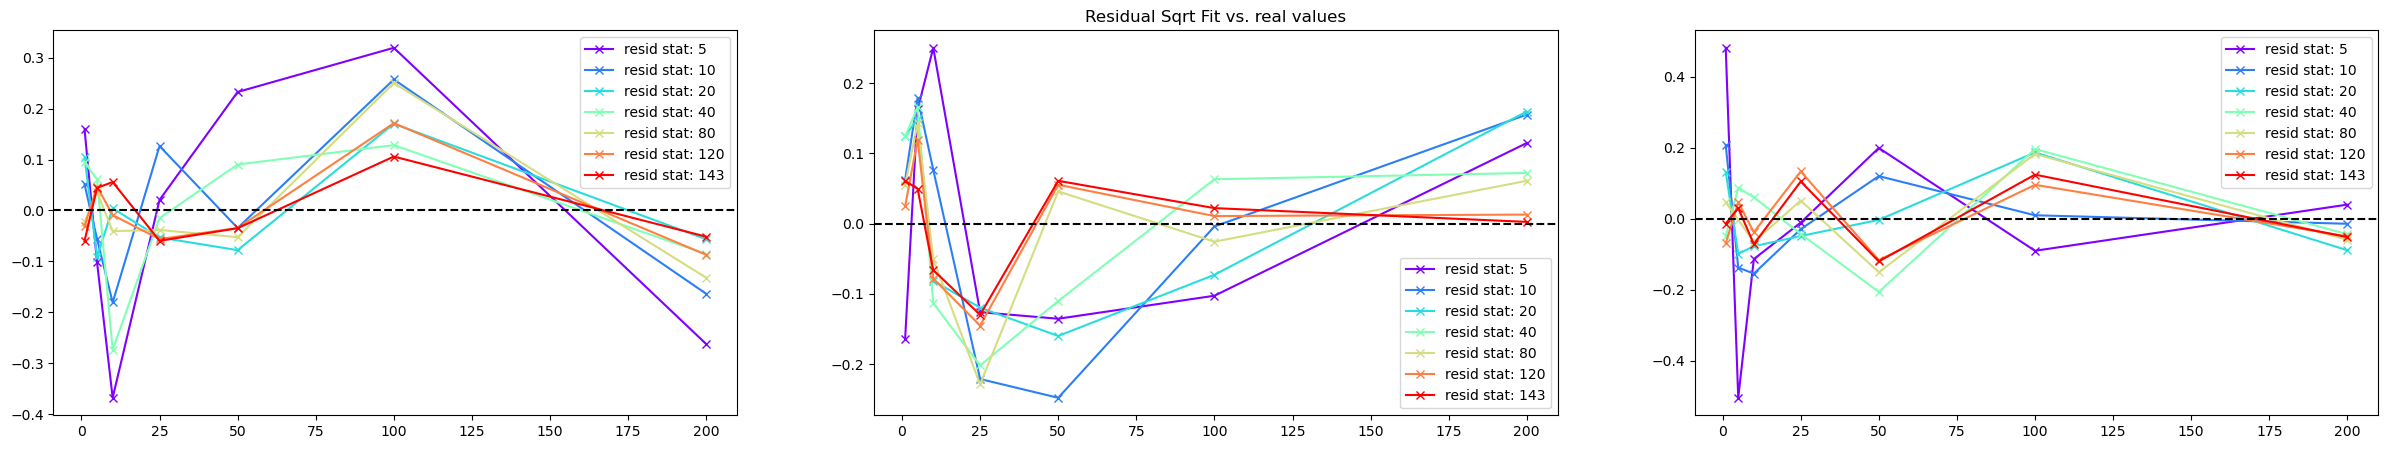

In [83]:
plt.ion()
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
fig.suptitle(f"{len_seeds}-AVG TS simulation ext: {ext:.2f} deg, norm={source_w.spectral_model.amplitude.value:.2e}, gamma={source_w.spectral_model.index.value:.2e}, src={src}")
seed_max = [5,10,20,40,80,120,143]
ax1.set_title("Sqrt Parameters vs. exposure")
ax1.errorbar(seed_max,A20,yerr=A20_err,marker='x',ls='-',label='A z20')
ax1.errorbar(seed_max,A30,yerr=A30_err,marker='x',ls='-',label='A z30')
ax1.errorbar(seed_max,A40,yerr=A40_err,marker='x',ls='-',label='A z40')
ax1.errorbar(seed_max,B20,yerr=B20_err,marker='x',ls='-',label='B z20')
ax1.errorbar(seed_max,B30,yerr=B30_err,marker='x',ls='-',label='B z30')
ax1.errorbar(seed_max,B40,yerr=B40_err,marker='x',ls='-',label='B z40')
ax1.axhline(0,ls='--',c='k')
ax1.legend()
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(30, 5))
ax2.set_title("Residual Sqrt Fit vs. real values")
color = iter(cm.rainbow(np.linspace(0, 1, num=len(seed_max))))
#col = next(color)
for s in range(len(seed_max)):
    col = next(color)    
    ax1.plot(exposure,resid20[s],marker='x',ls='-',label=f'resid stat: {seed_max[s]}', c=col)
    ax2.plot(exposure,resid30[s],marker='x',ls='-',label=f'resid stat: {seed_max[s]}', c=col)
    ax3.plot(exposure,resid40[s],marker='x',ls='-',label=f'resid stat: {seed_max[s]}', c=col)
for ax in [ax1,ax2,ax3]:
    ax.axhline(0,ls='--',c='k')
    ax.legend()